# Self Drivin Car Engineering Nanodegree


## Project: Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Step 0: Preparation

In [1]:
# Import necessary libraries
import os
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import display, HTML
from collections import deque

matplotlib.use("qt5agg")
%matplotlib inline

In [2]:
# Reads an image and converts it to RGB
def read_img(file_name):
    img = cv2.cvtColor(cv2.imread(file_name), cv2.COLOR_BGR2RGB)
    return img

# Save an image as RGB
def save_img(file_name, img):
    cv2.imwrite(file_name, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

## Step 1: Camera Calibration

In [3]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
matches = [] # indices of matched chessboard images

# List of calibration images
images = glob.glob("camera_cal/calibration*.jpg")

# Create folder for images
directory = "output_images/calibration/"
if not os.path.exists(directory):
    os.makedirs(directory)

# Loop over several grid variations as (9,6) and (9,5) were not able to cover all calibration images
for y in [5, 6]: 
    for x in [6,7,8,9]:
        grid = (x,y)
        # Prepare object points with z coordinate always zero as the chessboard is a plane
        objp = np.zeros((grid[0]*grid[1],3), np.float32)
        objp[:,:2] = np.mgrid[0:grid[0], 0:grid[1]].T.reshape(-1,2)

        # Loop over each calibration image
        for idx, file_name in enumerate(images):
            # Read in image as RGB
            img = read_img(file_name)
            # Convert image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # Find chessboard corners
            # The FAST_CHECK flag speeds up the process
            ret, corners = cv2.findChessboardCorners(img, grid, None, cv2.CALIB_CB_FAST_CHECK)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
                matches.append(idx)

                # Draw and display the corners
                cv2.drawChessboardCorners(img, grid, corners, ret)
                write_name = directory+"corners"+str(idx+1)+"_"+str(grid[0])+"_"+str(grid[1])+".jpg"
                save_img(write_name, img)
                # cv2.imshow('img', img)
                # cv2.waitKey(500)
                print("FOUND:\t\t {} - {}".format(grid, file_name))
            else:
                print("NOT FOUND:\t {} - {}".format(grid, file_name))

        # Close all windows that were opened
        cv2.destroyAllWindows()
print("-"*50)
print("{} overall detections".format(len(imgpoints)))
print("{} out of {} calibration images are at least once covered".format(np.unique(matches).shape[0], len(images)))

NOT FOUND:	 (6, 5) - camera_cal\calibration01.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration02.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration03.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration04.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration05.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration06.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration07.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration08.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration09.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration10.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration11.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration12.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration13.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration14.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration15.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration16.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration17.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration18.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration19.jpg
NOT FOUND:	 (6, 5) - camera_cal\calibration20.jpg


In [4]:
# TODO: Investigate why smaller grids are not detected in larger chessboards --> might be due to ambiguity?!

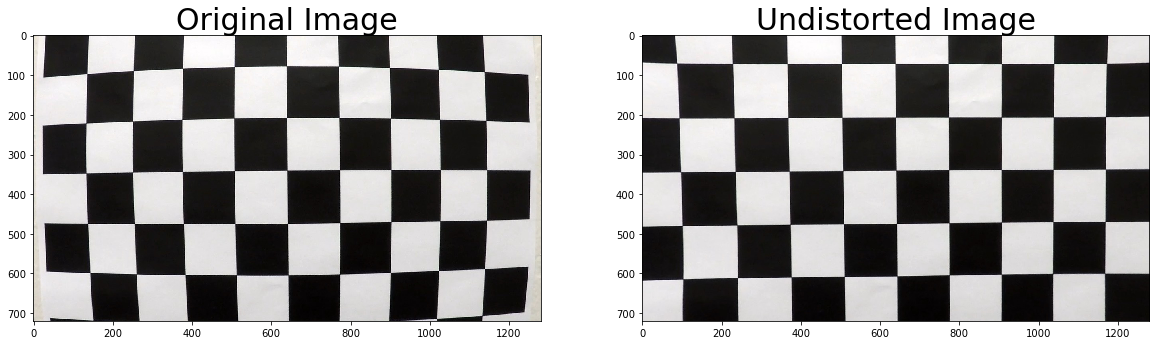

In [5]:
# Showcase undistortion
img = read_img("camera_cal/calibration01.jpg")
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
save_img(directory + "test_undist.jpg",dst)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title("Original Image", fontsize=30)
ax2.imshow(dst)
ax2.set_title("Undistorted Image", fontsize=30)
plt.show()

## Step 2: Pipeline

In [6]:
# TODO: Check how to create directory for images programmatically because cv2.imwrite does not do it automatically
# TODO: put color transform into a function

In [7]:
# Load test iamges 
images = glob.glob("test_images/test*.jpg")

# Create folder for images
directory = "output_images/pipeline/"
if not os.path.exists(directory):
    os.makedirs(directory)
    
# Loop over all test images 
for idx, file_name in enumerate(images):
    # Read in image and convert it to RGB
    img = read_img(file_name)
    # Undistort the test images
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    write_name = directory+"undist_test_"+str(idx+1)+".jpg"
    save_img(write_name, dst)
    print("SAVED: {}".format(write_name))

SAVED: output_images/pipeline/undist_test_1.jpg
SAVED: output_images/pipeline/undist_test_2.jpg
SAVED: output_images/pipeline/undist_test_3.jpg
SAVED: output_images/pipeline/undist_test_4.jpg
SAVED: output_images/pipeline/undist_test_5.jpg
SAVED: output_images/pipeline/undist_test_6.jpg


In [8]:
# Undistort image
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Apply Gaussian blur for noise filtering
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Transform color space of image
def transform_color_space(img, color_space):
    # Dictionary of color transform mappings
    transforms = {"HSV": cv2.COLOR_RGB2HSV, "HLS": cv2.COLOR_RGB2HLS, "XYZ": cv2.COLOR_RGB2XYZ,
                 "LUV": cv2.COLOR_RGB2LUV, "YUV": cv2.COLOR_RGB2YUV, "YCrCb": cv2.COLOR_RGB2YCrCb,
                 "GRAY": cv2.COLOR_RGB2GRAY, "Lab": cv2.COLOR_RGB2Lab}
    return cv2.cvtColor(img, transforms[color_space])

# Apply sobel thresholding
def sobel_thresh(img, orient="x", thresh_min=0, thresh_max=255):
    if len(img.shape) > 2:
        # Convert to grayscale
        img_sobel = transform_color_space(img, "GRAY")
    else:
        img_sobel = img
    # Apply x or y gradient and take the absolute value
    if orient == "x":
        abs_sobel = np.absolute(cv2.Sobel(img_sobel, cv2.CV_64F, 1, 0))
    if orient == "y":
        abs_sobel = np.absolute(cv2.Sobel(img_sobel, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Apply threshold
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

# Filter image for color 
def filter_channel(img, low_thresh, high_thresh):
    # Filter the color described through the thresholds
    detection = cv2.inRange(img, low_thresh, high_thresh)
    
    return detection
    
# Overlay several binary masks 
def overlay_masks(masks, mode="or"):
    if len(masks) >= 2:
        # Take one mask as starting point
        overlay = masks.pop()
        # Loop over all masks
        for mask in masks:
            # Put masks on top of each other
            overlay = cv2.bitwise_or(overlay, mask) if mode == "or" else cv2.bitwise_and(overlay, mask)
        return overlay
    elif len(masks) == 1:
        return masks

# Filter for lane lines
def filter_lane_lines(img):
    # Convert to HLS colorspace
    hls = transform_color_space(img, "HLS")
    lab = transform_color_space(img, "Lab")
    
    # Filter white areas
    white_low_thresh = np.uint8([0, 200, 0])
    white_high_thresh = np.uint8([255, 255, 255])
    white = filter_channel(hls, white_low_thresh, white_high_thresh)
    
    # Filter for l
    l_low_thresh = np.uint8([225])
    l_high_thresh = np.uint8([255])
    l = filter_channel(hls[:,:,1], l_low_thresh, l_high_thresh)

    # Filter for b
    b_low_thresh = np.uint8([155])
    b_high_thresh = np.uint8([200])
    b = filter_channel(lab[:,:,2], b_low_thresh, b_high_thresh)
    
    # Filter yellow areas
    yellow_low_thresh = np.uint8([10, 0, 100])
    yellow_high_thresh = np.uint8([40, 255, 255])
    yellow = filter_channel(hls, yellow_low_thresh, yellow_high_thresh)
    
    # Sobel edge detection for saturation channel
    #sobel_l = sobel_thresh(hls[:,:,1], "x", 20, 255)*255
    
    # Combine masks
    overlay = overlay_masks([white, yellow, l, b])
    # Convert to 3 channel image
    #overlay = np.dstack((overlay,overlay,overlay)).astype('uint8')
    
    return overlay

# Get mask for region of interest
def region_of_interest(img):
    # Defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Points that define the region of interest
    vertices = np.array(
    [[200, 0], 
     [1080, 0], 
     [880, 720],
     [400, 720]], dtype=np.int32)
    
    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Warp the image to desired perspective
def transform_bird_perspective(img, reverse=False):
    # Source points of the image for persepctive transform
    src = np.float32([[708,460], [1055,680], [250,680], [577,460]])
    # Destination points the source points should be mapped to
    dst = np.float32([[830,0], [830,720], [450,720], [450,0]])
    if not reverse:
        # Calculate the transformation matrix
        mtx = cv2.getPerspectiveTransform(src, dst)
    else:
        # Calculate reverse transformation matrix
        mtx = cv2.getPerspectiveTransform(dst, src)
    # Warp image to desired persepctive
    img_warped = cv2.warpPerspective(img, mtx, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    return img_warped

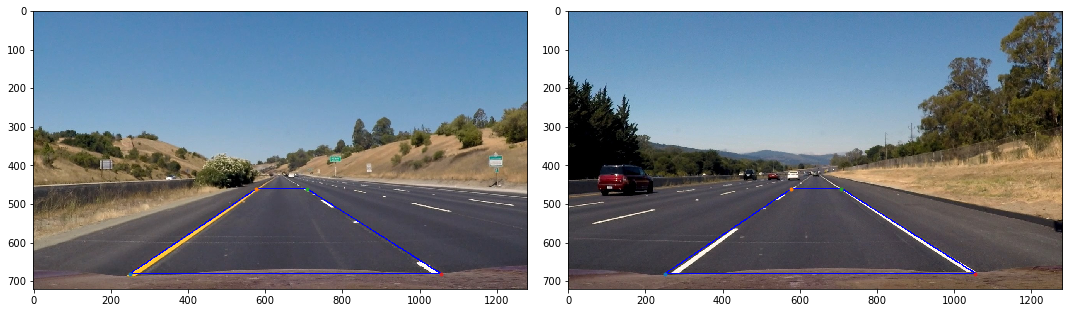

In [9]:
# Load test iamges 
images = glob.glob("test_images/straight_lines*.jpg")
plt.figure(figsize=(15,15))

# Proposal for source points of warp function
src = [[250,680], [577,460], [708,460], [1055,680]]

# Loop over the images
for idx, file_name in enumerate(images):
    # Load image
    img = read_img(file_name)
    
    #Draw outline of the box
    cv2.polylines(img, np.array([src], dtype=np.int32), 1, (0,0,255), thickness=2)
    
    # Plot image with target dots
    plt.subplot(1, len(images), idx+1)
    plt.imshow(img)
    plt.plot(*src[0], ".")
    plt.plot(*src[1], ".")
    plt.plot(*src[2], ".")
    plt.plot(*src[3], ".")

plt.tight_layout()
plt.savefig(directory+"warp_area.png")

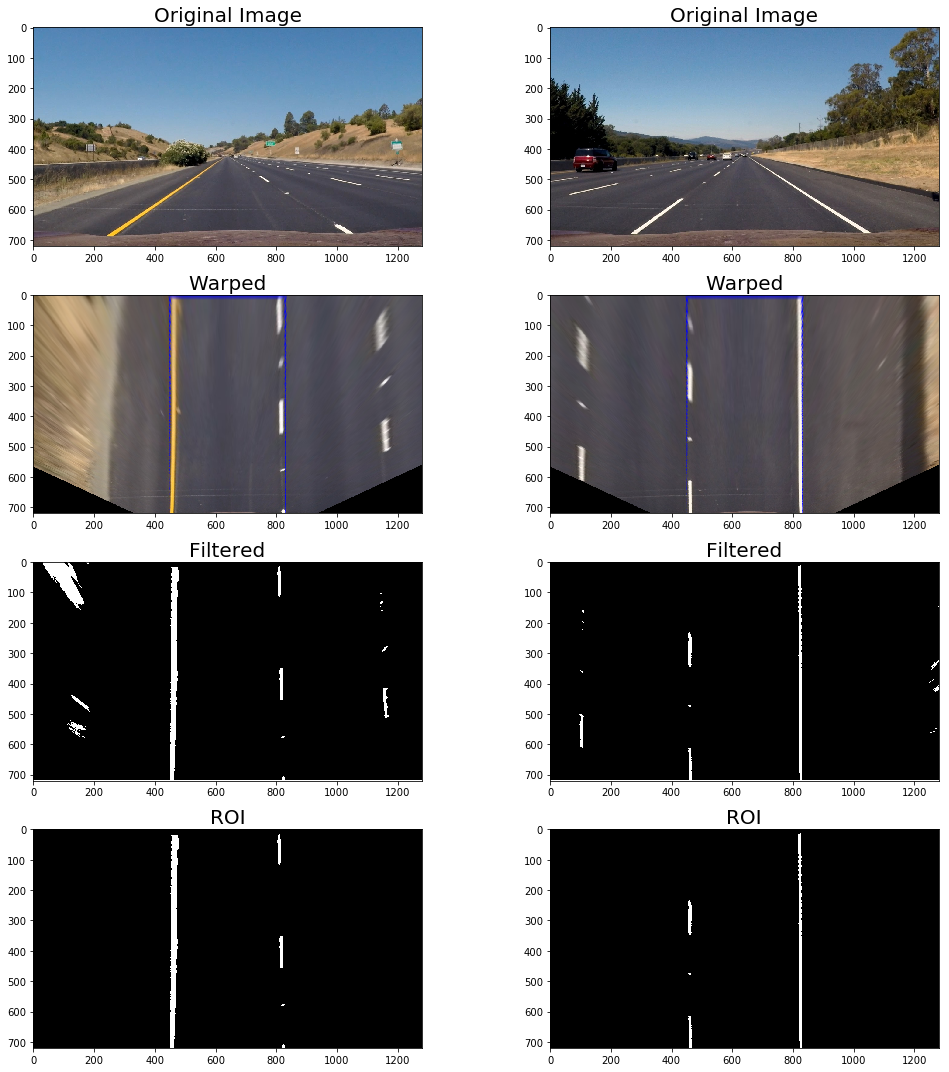

In [10]:
# Check the result of perspective transform
fig = plt.figure(figsize=(15,15))

# Loop over the images
for idx, file_name in enumerate(images):
    # Load image
    img = read_img(file_name)
    plt.subplot(4, len(images), idx+1)
    plt.imshow(img)
    plt.title("Original Image", fontsize=20)
    
    # Undistort image
    img_undist = undistort(img, mtx, dist)
    
    #Draw outline of the box
    cv2.polylines(img_undist, np.array([src], dtype=np.int32), 1, (0,0,255), thickness=1)
    
    # Transform perspective
    img_warped = transform_bird_perspective(img_undist)
    plt.subplot(4, len(images), idx+3)
    plt.imshow(img_warped)
    plt.title("Warped", fontsize=20)
    
    # Filter for lane lines
    img_filtered = filter_lane_lines(img_warped)
    plt.subplot(4, len(images), idx+5)
    plt.imshow(img_filtered, cmap="gray")
    plt.title("Filtered", fontsize=20)
    
    # Get region of interest
    img_roi = region_of_interest(img_filtered)
    plt.subplot(4, len(images), idx+7)
    plt.imshow(img_roi, cmap="gray")
    plt.title("ROI", fontsize=20)
    
plt.tight_layout()
plt.show()
fig.savefig(directory+"pipeline.png")

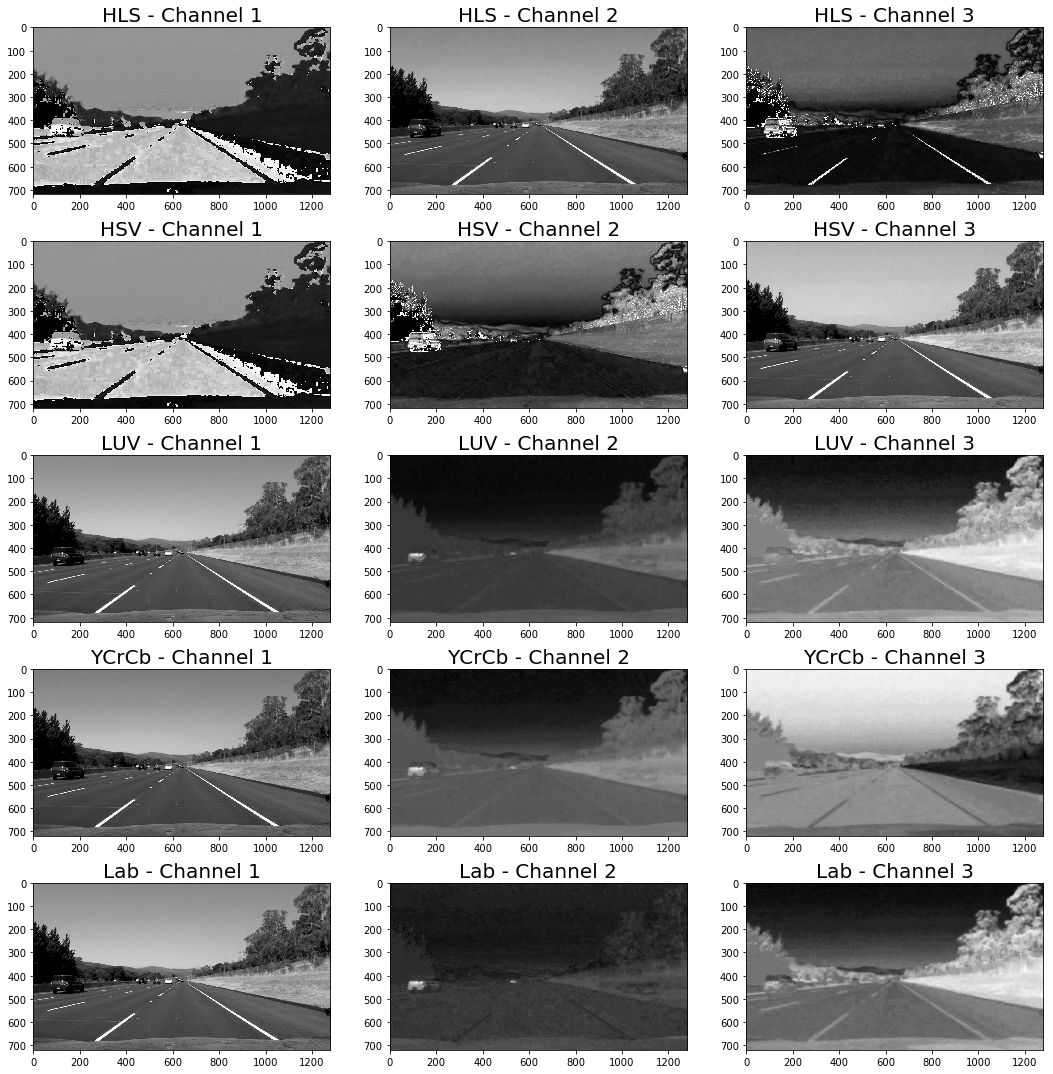

In [11]:
# Test different colorspaces
plt.figure(figsize=(15,15))
colorspaces = ["HLS", "HSV", "LUV", "YCrCb", "Lab"]
for idx, cspace in enumerate(colorspaces):
    for i in range(img.shape[2]):
        plt.subplot(len(colorspaces),3,i+1+idx*3)
        plt.imshow(transform_color_space(img, cspace)[:,:,i], cmap="gray")
        plt.title("{} - Channel {}".format(colorspaces[idx], i+1), fontsize=20)

plt.tight_layout()
plt.savefig(directory+"color_spaces.png")
plt.show()

In [12]:
# Pipeline to get lane line information
def test_pipeline(img):
    # Undistort image
    img_undist = undistort(img, mtx, dist)
    
    # Transform perspective
    img_warped = transform_bird_perspective(img_undist)
    
    # Filter for lane lines
    img_filtered = filter_lane_lines(img_warped)
    
    # Get region of interest
    img_roi = region_of_interest(img_filtered)

    return img_roi, img_warped, img_undist

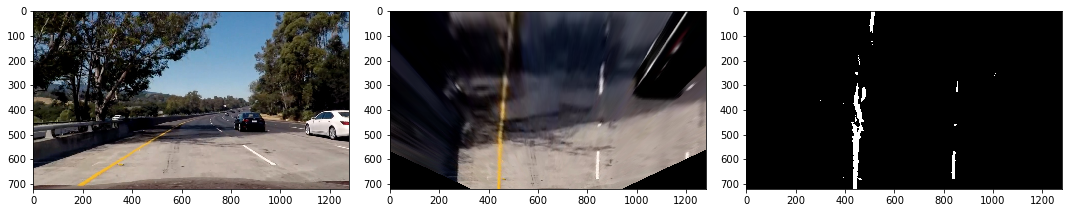

In [13]:
# Check pipeline on test images
# Load test iamges 
file_name = "test_images/test5.jpg"
# Read in image and convert it to RGB
img = read_img(file_name)
# Undistort the test images
roi, warp, undist = test_pipeline(img)
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(undist)
plt.subplot(132)
plt.imshow(warp)
plt.subplot(133)
plt.imshow(roi, cmap="gray")
plt.tight_layout()
plt.show()

In [23]:
# Get the starting positions of the left and right lane
def find_lane_start_positions(binary_img):
    # Compute the sum over columns for the bottom half of the image
    histogram = np.sum(binary_img[binary_img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_img, binary_img, binary_img))
    # Find the peaks of the left and right halves of the histogram
    mid = np.int(histogram.shape[0]/2)
    left_base = np.argmax(histogram[:mid])
    right_base = np.argmax(histogram[mid:]) + mid
    
    return left_base, right_base

def find_lane_from_start(binary_img, n_windows, start_pos):
    # Set height of windows
    window_height = np.int(binary_img.shape[0]/n_windows)
    # Identify the x and y positions of all nonzero pixels
    nonzero = binary_img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    # Current positions to be updated for each window
    current_pos = start_pos
    # Set the width of the window +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right pixel indices
    lane_inds = []
    
    # Image for output
    out_img = np.dstack((binary_img, binary_img, binary_img))
    
    # Step through the windows
    for window in range(n_windows):
        # Identify window boundaries in x and y 
        win_y_low = binary_img.shape[0] - (window+1) * window_height
        win_y_high = binary_img.shape[0] - window * window_height
        win_x_low = current_pos - margin
        win_x_high = current_pos + margin
        # Draw the windows on the output image
        cv2.rectangle(out_img, (win_x_low, win_y_low), (win_x_high, win_y_high), (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        fits = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_x_low) & 
                     (nonzero_x < win_x_high)).nonzero()[0]
        # Append these fits to the list
        lane_inds.append(fits)
        # If more than minpix pixels are found then recenter the window
        if len(fits) > minpix:
            current_pos = np.int(np.mean(nonzero_x[fits]))
    # Concatenate the findings of lanes
    lane_inds = np.concatenate(lane_inds)
        
    # Extract left and right line pixel positions
    x_pos = nonzero_x[lane_inds]
    y_pos = nonzero_y[lane_inds]
    
    return x_pos, y_pos, out_img

# Fit a second order polynomial
def fit_polynomial(img, x_pos, y_pos):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    # Fit polynomial
    poly = np.polyfit(y_pos, x_pos, 2)
    # Generate x and y values for plotting
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x = poly[0] * ploty**2 + poly[1] * ploty + poly[2]
    
    return poly, x, y

# Fit polynomial from detected line
def find_lane_from_polynomial(binary_img, poly):
    # Identify the x and y positions of all nonzero pixels
    nonzero = binary_img.nonzero()
    nonzero_y  = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    # Set the margin to search around the line
    margin = 100
    # Get pixel coordinates within the margin
    lane_inds = ((nonzero_x > poly[0]*nonzero_y**2 + poly[1]*nonzero_y + poly[2]  - margin) & 
                (nonzero_x < poly[0]*nonzero_y**2 + poly[1]*nonzero_y + poly[2] + margin))
    # Extract line pixel positions
    x_pos = nonzero_x[lane_inds]
    y_pos = nonzero_y[lane_inds]
    
    return x_pos, y_pos

# Compute curvature of the polynomial
def compute_curvature(poly, ploty):
    # Define y-value where to compure radius of curvature
    y_eval = np.max(ploty)
    # Compute curve radius
    curve_rad = ((1 + (2*poly[0]*y_eval + poly[1])**2)**1.5) / np.absolute(2*poly[0])
    
    return curve_rad

# Convert pixel space coordinates to real space
def convert_pixel_to_real(x_pos, y_pos):
    # Conversions from pixel space to meters
    ym_per_pix = 30/720 # Meters per pixel in y dimension
    xm_per_pix = 3.7/700 # Meters per pixel in x dimension
    
    return x_pos*xm_per_pix, y_pos*ym_per_pix

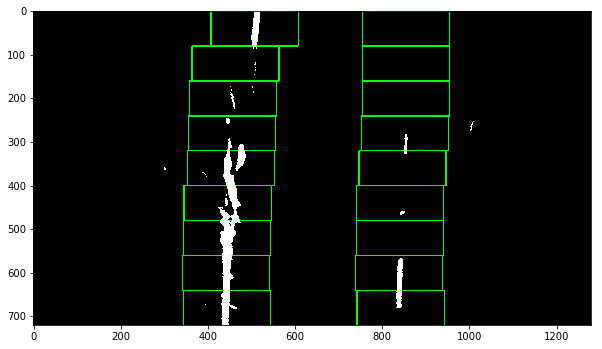

In [15]:
left_start, right_start = find_lane_start_positions(roi)
xr,yr,outr = find_lane_from_start(roi, 9, left_start)
xl,yl,outl = find_lane_from_start(roi, 9, right_start)
out = np.bitwise_or(outl,outr)
plt.figure(figsize=(10,10))
plt.imshow(out)
plt.show()

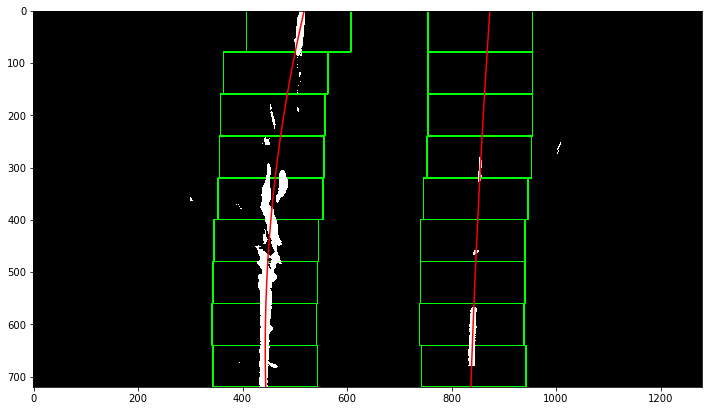

In [16]:
_, leftx, lefty = fit_polynomial(roi,xl,yl)
_, rightx, righty = fit_polynomial(roi,xr,yr)
plt.figure(figsize=(10,10))
plt.imshow(out, cmap="gray")
plt.plot(rightx, righty, color="red")
plt.plot(leftx, lefty, color="red")
plt.tight_layout()
plt.show()

In [17]:
# Draw the lane 
def show_lane(img,left_lane,right_lane,ploty):
    
    # Create an image to draw the lane on
    out_img = np.zeros_like(img).astype(np.uint8)

    # Get points to fill polygon
    left_pts = np.array([np.transpose(np.vstack([left_lane, ploty]))])
    right_pts = np.array([np.flipud(np.transpose(np.vstack([right_lane, ploty])))])
    pts = np.hstack((left_pts, right_pts))

    # Draw the lane 
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))
    
    return out_img

# Overlay two images
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

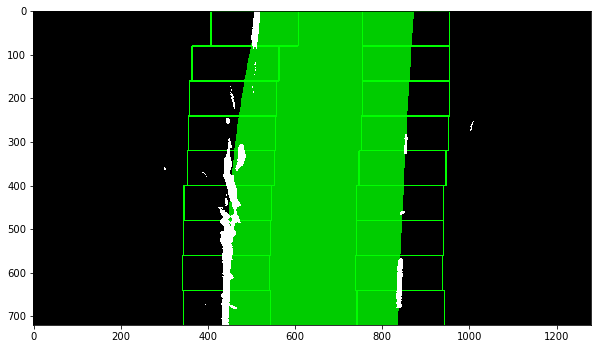

In [18]:
lane = show_lane(out, leftx, rightx, righty)
out_img = weighted_img(out, lane)
plt.figure(figsize=(10,10))
plt.imshow(out_img)
plt.show()

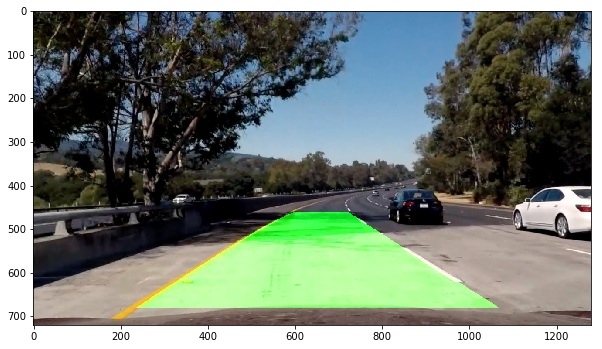

In [19]:
lane_unwarped = transform_bird_perspective(lane, reverse=True)
result = weighted_img(undist, lane_unwarped)
plt.figure(figsize=(10,10))
plt.imshow(result)
plt.show()

In [24]:
class Line():
    def __init__(self, dim_x=1280, dim_y=720, conv_y_pix_m=30/720, conv_x_pix_m=3.7/700, n=10):
        # Number of frames to consider from the past
        self.n = n
        # Was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([], maxlen=n) 
        # Polynomial coefficient of the last n fits
        self.recent_fits = deque([], maxlen=n)
        # Average x values of the fitted line over the last n iterations
        self.bestx = None     
        # Polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # Polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # Radius of curvature of the line in meter
        self.radius_of_curvature = None 
        # Distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # Difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        # y values of the polynom
        self.ploty = np.linspace(0, dim_y-1, dim_y)
        # x values of the polynom
        self.plotx = None
        # Conversion rate y pixel to m
        self.conv_y_pix_m = conv_y_pix_m
        # Conversion rate x pixel to m
        self.conv_x_pix_m = conv_x_pix_m
        # Center of the image
        self.center = dim_x//2
        
    def set_plotx(self):
        poly = self.current_fit
        ploty = self.ploty
        self.plotx = poly[0]*ploty**2 + poly[1]*ploty + poly[2]        
    
    def set_line_base_pos(self):
        center = self.center
        base = self.plotx[-1]
        self.line_base_pos = self.convert_pix_m(np.absolute(center-base), self.conv_x_pix_m)
        
    def convert_pix_m(self, pix, rate):
        return pix * rate
    
    def set_curvature(self):
        if self.bestx is not None:
            y = self.convert_pix_m(self.ploty, self.conv_y_pix_m)
            x = self.convert_pix_m(self.bestx, self.conv_x_pix_m)
            y_eval = np.max(y)
            poly = np.polyfit(y, x, 2)
            self.radius_of_curvature = ((1 + (2*poly[0]*y_eval + poly[1])**2)**1.5) / np.absolute(2*poly[0])
    
    def set_diffs(self):
        if self.best_fit is not None:
            self.diffs = np.absolute(self.current_fit - self.best_fit)       
    
    def check_acceptability(self):
        if self.line_base_pos > 2.5:
            return False
        elif self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.0:
            return False
        return True
    
    def update(self, lane_x, lane_y):
        self.allx = lane_x
        self.ally = lane_y
        self.current_fit = np.polyfit(self.ally, self.allx, 2)
        self.set_plotx()
        self.set_curvature()
        self.set_line_base_pos()
        self.set_diffs()
        if True:# self.check_acceptability():
            self.detected = True
            self.recent_xfitted.appendleft(self.plotx)
            self.recent_fits.appendleft(self.current_fit)
            self.bestx = np.mean(self.recent_xfitted, axis=0) 
            self.best_fit = np.mean(self.recent_fits, axis=0)
        else:
            try:
                self.recent_xfitted.pop()
                self.bestx = np.mean(self.recent_xfitted, axis=0)
                if len(self.recent_xfitted) == 0:
                    self.bestx = None
                    self.detected = False
            except IndexError:
                pass
            try:
                self.recent_fits.pop()
                self.best_fit = np.mean(self.recent_fits, axis=0)
                if len(self.recent_fits) == 0:
                    self.best_fit = None
                    self.diffs = np.array([0,0,0], dtype='float')
            except:
                pass

In [25]:
# Load camera settings
data =  pickle.load(open( "dist_pickle.p", "rb" ))
mtx = data["mtx"]
dist = data["dist"]

def pipeline(img):
    global left, right
    # Undistort the image
    img_undist = undistort(img, mtx, dist)
    # Transform perspective
    img_warped = transform_bird_perspective(img_undist)
    # Filter for lane lines
    img_filtered = filter_lane_lines(img_warped)
    # Get region of interest
    img_roi = region_of_interest(img_filtered)
    # If lane already detected take it as starting point
    if left.detected and right.detected:
        # Get coordinates of the pixels that should be considered
        left_x, left_y = find_lane_from_polynomial(img_roi, left.best_fit)
        right_x, right_y = find_lane_from_polynomial(img_roi, right.best_fit)
    # Else find starting positions and get polynomial
    else:
        # Get start positions of the lane lines
        left_start, right_start = find_lane_start_positions(img_roi)
        # Get coordinates of the pixels that should be considered
        left_x, left_y, _ = find_lane_from_start(img_roi, 9, left_start)
        right_x, right_y, _ = find_lane_from_start(img_roi, 9, right_start)
    # Update the lines with new lines
    if left_x.size: left.update(left_x, left_y)
    if right_x.size: right.update(right_x, right_y)
        
    if left.detected and right.detected:
        # Calculate the distance between the lines
        line_distance = np.absolute(left.line_base_pos-right.line_base_pos)
        if line_distance < 1.3 or line_distance > 4.3:
            left.detected = False
            right.detected = False
        # Check if they have the same curvature by checking parallelism
        parallelism = right.bestx - left.bestx
        if any((parallelism > 800)) or any((parallelism < 400)):
            left.detected = False
            right.detected = False
        # Get polynomial coordinates of the lane lines
        leftx, lefty = left.bestx, left.ploty
        rightx, righty = right.bestx, right.ploty
        # Get filled lane polygon
        lane = show_lane(np.dstack((img_roi, img_roi, img_roi)), leftx, rightx, righty)
        # Warp the lane back to normal perspective
        lane_unwarped = transform_bird_perspective(lane, reverse=True)
        # Overlay the lane with the image
        result = weighted_img(img_undist, lane_unwarped)
        # Calculate curvature
        left_radius = left.radius_of_curvature
        right_radius = right.radius_of_curvature
        curvature = "-"
        if left_radius and right_radius:
            curve_diff = np.absolute(left_radius-right_radius)
            curvature = round((left_radius + right_radius)/2, 2)
        curvature_txt  = "radius: {}m".format(curvature)
        cv2.putText(result, curvature_txt, (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
        # Calculate offset to center of the lane
        left_offset = left.line_base_pos
        right_offset = right.line_base_pos
        offset = "-"
        if left_offset and right_offset:
            sign = -1 if right_offset > left_offset else +1
            offset = sign * round(np.absolute((left_offset-right_offset)/2) * 100, 2)
        offset_txt = "center offset: {}cm".format(offset)
        cv2.putText(result, offset_txt, (40,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    else:
        result = img_undist
        img_txt = "NO LANE DETECTED"
        cv2.putText(result, img_txt, (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    return result

In [26]:
left = Line()
right = Line()

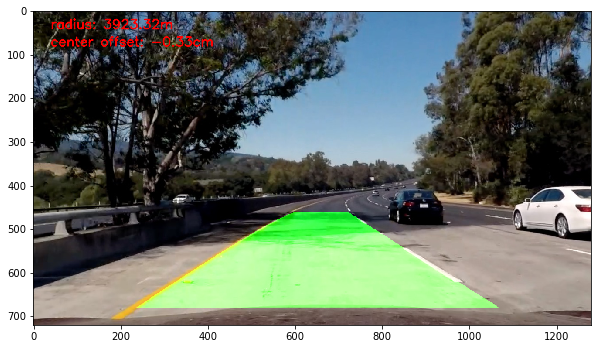

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(pipeline(img))

In [29]:
# Test Video
left = Line()
right = Line()

video_output = "project_test_result.mp4"
clip = VideoFileClip("test_video.mp4")
output_clip = clip.fl_image(pipeline)
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_test_result.mp4
[MoviePy] Writing video project_test_result.mp4


 97%|█████████▋| 38/39 [00:04<00:00,  9.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_test_result.mp4 

Wall time: 5.97 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [31]:
# Project Video
left = Line()
right = Line()

video_output = "project_result.mp4"
clip = VideoFileClip("project_video.mp4")
output_clip = clip.fl_image(pipeline)
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|█████████▉| 1260/1261 [02:41<00:00,  7.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 

Wall time: 2min 42s


In [32]:
clip = VideoFileClip("project_result.mp4").subclip(38.0, 41.0)
clip.write_gif("result.gif", fps=25)


[MoviePy] Building file result.gif with imageio


 99%|█████████▊| 75/76 [00:28<00:00,  2.77it/s]


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))